In [15]:
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
import os

In [8]:
file_path = os.path.join(os.getcwd(), "data", "Chr1.phylop.final.bed.gz")

df = pd.read_csv(file_path, sep="\t", header=0, low_memory=False, compression='gzip')

df.head(20)

,#chr,start,end,phyloP_-log_pvalue
0,Chr1,0,1,1.946
1,Chr1,1,2,2.285
2,Chr1,2,3,2.388
3,Chr1,3,4,1.772
4,Chr1,4,5,-0.911
5,Chr1,5,6,0.978
6,Chr1,6,7,2.201
7,Chr1,7,8,-0.769
8,Chr1,8,9,2.943
9,Chr1,9,10,0.345


In [9]:
df["p_value"] = 10 ** (-df["phyloP_-log_pvalue"]) # Преобразуем -log(p-value) обратно в p-value
df.head(20)

,#chr,start,end,phyloP_-log_pvalue,p_value
0,Chr1,0,1,1.946,0.011324
1,Chr1,1,2,2.285,0.005188
2,Chr1,2,3,2.388,0.004093
3,Chr1,3,4,1.772,0.016904
4,Chr1,4,5,-0.911,8.147043
5,Chr1,5,6,0.978,0.105196
6,Chr1,6,7,2.201,0.006295
7,Chr1,7,8,-0.769,5.874894
8,Chr1,8,9,2.943,0.001140
9,Chr1,9,10,0.345,0.451856


In [10]:
# Применяем FDR-коррекцию (Benjamini-Hochberg)
_, q_values, _, _ = multipletests(df["p_value"], method='fdr_bh')

# Добавляем q-values в таблицу
df["q_value"] = q_values

# Определяем значимые позиции (q ≤ 0.05)
df["significant"] = df["q_value"] <= 0.05

# Категоризация по phyloP score:
#   - phyloP > 0 → консервативный (отрицательный отбор)
#   - phyloP < 0 → ускоренный (положительный отбор)
df["constraint_type"] = np.where(
    (df["significant"]) & (df["phyloP_-log_pvalue"] > 0), "constrained",
    np.where((df["significant"]) & (df["phyloP_-log_pvalue"] < 0), "accelerated", "neutral")
)

# Сохраняем результаты
df.to_csv("phyloP_corrected.csv", sep="\t", index=False)
df.head(20)

,#chr,start,end,phyloP_-log_pvalue,p_value,q_value,significant,constraint_type
0,Chr1,0,1,1.946,0.011324,0.066386,False,neutral
1,Chr1,1,2,2.285,0.005188,0.036360,True,constrained
2,Chr1,2,3,2.388,0.004093,0.029493,True,constrained
3,Chr1,3,4,1.772,0.016904,0.089764,False,neutral
4,Chr1,4,5,-0.911,8.147043,1.000000,False,neutral
5,Chr1,5,6,0.978,0.105196,0.371019,False,neutral
6,Chr1,6,7,2.201,0.006295,0.041941,True,constrained
7,Chr1,7,8,-0.769,5.874894,1.000000,False,neutral
8,Chr1,8,9,2.943,0.001140,0.010205,True,constrained
9,Chr1,9,10,0.345,0.451856,0.972850,False,neutral


In [11]:
# Отбираем только значимые консервативные позиции (q ≤ 0.05 и phyloP > 0)
constrained_df = df[(df["significant"]) & (df["phyloP_-log_pvalue"] > 0)]

# **1. Поиск кластеров консервативных позиций длиной ≥ 20 bp**
constrained_regions = []
for chr_name, group in constrained_df.groupby("#chr"): # разбивает constrained_df на отдельные группы по хромосомам
                                                       # group — DataFrame со всеми значимыми позициями для этой хромосомы.
    positions = group["start"].tolist() # Извлекаем список координат стартовых позиций значимых нуклеотидов.
    clusters = []
    
    # Группируем соседние позиции в кластеры
    for k, g in groupby(enumerate(positions), lambda x: x[0] - x[1]):
        cluster = list(map(lambda x: x[1], g))
        if len(cluster) >= 20:
            clusters.append((chr_name, cluster[0], cluster[-1]))

    constrained_regions.extend(clusters)

# Создаём DataFrame с консервативными регионами
conserved_regions_df = pd.DataFrame(constrained_regions, columns=["chr", "start", "end"])

In [17]:
# **2. Разбивка генома на 100-кб окна**
bin_size = 100000
bins = []
for chr_name, group in df.groupby("#chr"):
    max_pos = group["end"].max()
    
    # Разделяем хромосому на 100-кб интервалыm
    for start in range(0, max_pos, bin_size):
        end = min(start + bin_size, max_pos)
        
        # Оптимизированный подсчет консервативных позиций в 100 кб окнах
        conserved_count = ((conserved_regions_df["chr"] == chr_name) & 
                           (conserved_regions_df["start"] >= start) & 
                           (conserved_regions_df["end"] <= end)).sum()
        
        fraction_conserved = conserved_count / bin_size
        bins.append((chr_name, start, end, fraction_conserved))

# Создаём DataFrame для 100-кб бинов
bins_df = pd.DataFrame(bins, columns=["chr", "start", "end", "fraction_conserved"])

In [18]:
# **3. Выявление участков с высокой/низкой консервативностью**
threshold_high = bins_df["fraction_conserved"].quantile(0.95)  # Топ-5% бинов
threshold_low = bins_df["fraction_conserved"].quantile(0.05)   # Нижние 5%

bins_df["constraint_level"] = np.where(
    bins_df["fraction_conserved"] >= threshold_high, "high_constraint",
    np.where(bins_df["fraction_conserved"] <= threshold_low, "low_constraint", "neutral")
)

# Сохранение результатов
conserved_regions_df.to_csv("conserved_regions.bed", index=False, sep="\t")
bins_df.to_csv("100kb_constraint_bins.bed", index=False, sep="\t")

# Вывод первых строк для проверки
print("Conserved regions:")
print(conserved_regions_df.head())

print("\n100-kb bins with constraint levels:")
print(bins_df.head())

Conserved regions:
    chr   start     end
0  Chr1   13695   13717
1  Chr1   36642   36661
2  Chr1   78931   78951
3  Chr1  130550  130577
4  Chr1  188579  188598

100-kb bins with constraint levels:
    chr   start     end  fraction_conserved constraint_level
0  Chr1       0  100000             0.00003  high_constraint
1  Chr1  100000  200000             0.00002          neutral
2  Chr1  200000  300000             0.00000   low_constraint
3  Chr1  300000  400000             0.00003  high_constraint
4  Chr1  400000  500000             0.00000   low_constraint


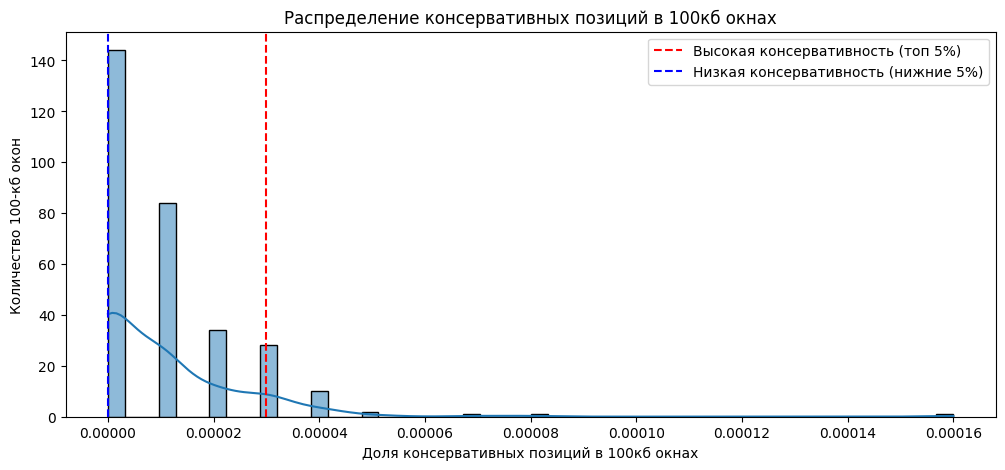

In [19]:
# **5. Визуализация распределения консервативности по 100-кб окнам**
plt.figure(figsize=(12, 5))
sns.histplot(bins_df["fraction_conserved"], bins=50, kde=True)

# Верхние 5% консервативных регионов
plt.axvline(threshold_high, color='red', linestyle='dashed', label="Высокая консервативность (топ 5%)")
# Нижние 5% менее консервативных регионов
plt.axvline(threshold_low, color='blue', linestyle='dashed', label="Низкая консервативность (нижние 5%)")

plt.xlabel("Доля консервативных позиций в 100кб окнах")
plt.ylabel("Количество 100-кб окон")
plt.title("Распределение консервативных позиций в 100кб окнах")
plt.legend()